In [1]:
import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm
import scipy.integrate as integrate
from scipy.optimize import minimize
from scipy.special import logsumexp
from tqdm import tqdm
import emcee
import corner

from astropy import units as u 
from astropy.table import Table
from math import *

from snewpy.neutrino import ThreeFlavor, MassHierarchy, MixingParameters, ThreeFlavorMixingParameters,FourFlavorMixingParameters
from snewpy.models.ccsn import Nakazato_2013
from snewpy.models.ccsn import Fornax_2022
from snewpy.models.ccsn import Bollig_2016
from snewpy.models.ccsn import Sukhbold_2015
from snewpy.models.ccsn import Zha_2021
from snewpy.models.ccsn import Tamborra_2014
from snewpy.flavor_transformation import AdiabaticMSW, NonAdiabaticMSWH, \
                                         TwoFlavorDecoherence, ThreeFlavorDecoherence, \
                                         NeutrinoDecay, AdiabaticMSWes, NonAdiabaticMSWes
#from asteria import set_rcparams
from asteria.simulation import Simulation

%matplotlib inline

ha


In [2]:
sukh_param_sfho=list(params for params in Sukhbold_2015.get_param_combinations() if params['progenitor_mass'].value == 27 
                      and params['eos']=='SFHo')
sukh_param_ls220=list(params for params in Sukhbold_2015.get_param_combinations() if params['progenitor_mass'].value == 27 
                      and params['eos']=='LS220')


forn_param=list(params for params in Fornax_2022.get_param_combinations() if params['progenitor_mass'].value == 26.99)

zha_param=list(params for params in Zha_2021.get_param_combinations() if params['progenitor_mass'].value == 26)

tamb_param=list(params for params in Tamborra_2014.get_param_combinations() if params['progenitor_mass'].value == 27
               and params['direction']==1)

In [3]:
sukh_model_sfho = {'name': 'Sukhbold_2015',
            'param': sukh_param_sfho[0]
              }

sukh_model_ls220 = {'name': 'Sukhbold_2015',
            'param': sukh_param_ls220[0]
              }

forn_model = {'name': 'Fornax_2022',
            'param': forn_param[0]
              }

zha_model = {'name': 'Zha_2021',
            'param': zha_param[0]
              }

tamb_model = {'name': 'Tamborra_2014',
            'param': tamb_param[0]
              }

In [5]:
models=[sukh_model_sfho,sukh_model_ls220,forn_model,zha_model,tamb_model]
labels=['nmo','imo']
hie=['normal','inverted']
mod_names=['sukh_sfho','sukh_ls220','forn','zha','tamb']

sims = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

for i,mod in enumerate(models):
    for j,lab in enumerate(labels):
        if mod['name']=='Fornax_2022':
            with open("ThreeFlavor_{}_M={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value,
                                                    lab), 'rb') as f:
                sims[mod_names[i]].append(pickle.load(f))
        else:
            with open("Three_Flavor_{}_M={}_eos={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value,
                                                        mod['param']['eos'],
                                                        lab), 'rb') as f:
                sims[mod_names[i]].append(pickle.load(f))

In [6]:
hits_tot = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

hits_norm = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

hits_shift = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

dt=10*u.ms
#max_t_dat = t1[np.argmax(norm_data_hits[0])]
for i,mod in enumerate(mod_names):
    for j in range(2):
        simm=sims[mod][j]
        simm.rebin_result(dt)
        simm.scale_result(10*u.kpc)
        t, hits = simm.detector_signal(dt)
        id5=np.where(t==.02*u.s)[0][0]
        id6=np.where(t==.46*u.s)[0][0]
        
        data=hits[id5:id6]
        hits_tot[mod].append(data) 
        
        s=np.sum(data)
        m=np.max(data)
        ta=data[np.where(t[id5:id6]==.4*u.s)[0][0]]
        norm_hits_sum=data/s
        
        hits_norm[mod].append(norm_hits_sum) 


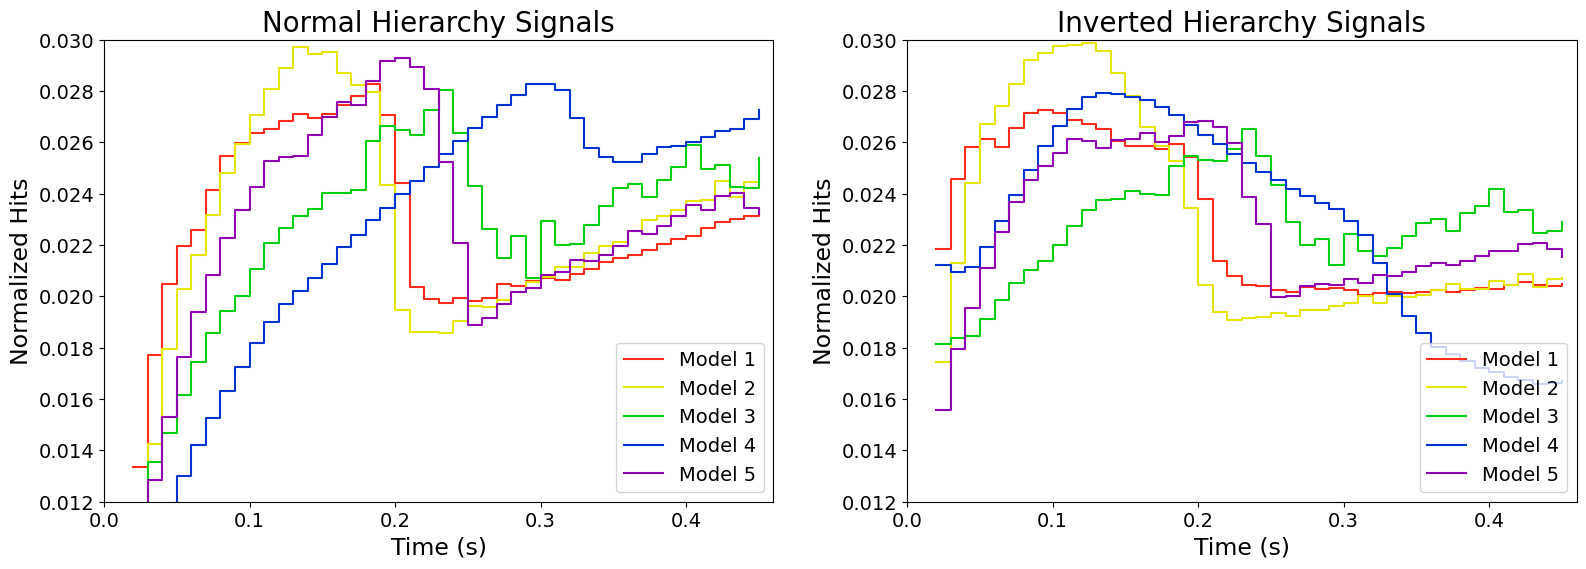

In [7]:
colors_nmo=['#fc2b1c','#e6e602','#02cf13','#0232cf','#9200b3']
colors_imo=['#fc968b','#faf1b1','#7ffc72','#91aafa','#e88bfc']
mod_names=['sukh_sfho','sukh_ls220','forn','zha','tamb']
mod_labs=['Model 1','Model 2','Model 3','Model 4','Model 5']


fig, axes = plt.subplots(1, 2, figsize=(19, 6))
axes = axes.flatten()
for i,mod in enumerate(mod_names):
    axes[0].step(t[id5:id6], hits_norm[mod][0], where='post',color=colors_nmo[i],label=f'{mod_labs[i]}')

axes[0].legend(loc='lower right',fontsize=14)
axes[0].set_xlim(0,.46)
axes[0].set_ylim(.012,.03)
axes[0].set_xlabel('Time (s)',fontsize=17)
axes[0].set_ylabel('Normalized Hits',fontsize=17)
axes[0].set_title('Normal Hierarchy Signals',fontsize=20)
axes[0].tick_params(axis='both', which='major', labelsize=14)

for i,mod in enumerate(mod_names):
    axes[1].step(t[id5:id6], hits_norm[mod][1], where='post',color=colors_nmo[i],label=f'{mod_labs[i]}')

axes[1].legend(loc='lower right',fontsize=14)
axes[1].set_xlim(0,.46)
axes[1].set_ylim(.012,.03)
axes[1].set_xlabel('Time (s)',fontsize=17)
axes[1].set_ylabel('Normalized Hits',fontsize=17)
axes[1].set_title('Inverted Hierarchy Signals',fontsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=14)
plt.savefig('norm_sig_indep.png', dpi=300, bbox_inches='tight')

In [25]:
ratios_nh=np.load('sukh_sfho_nh_probs_1_iter.npz',allow_pickle=True)['arr_0']
ratios=np.load('sukh_sfho_ih_probs_1_iter.npz',allow_pickle=True)['arr_0']
ratios=ratios.item()
ratios_nh=ratios_nh.item()

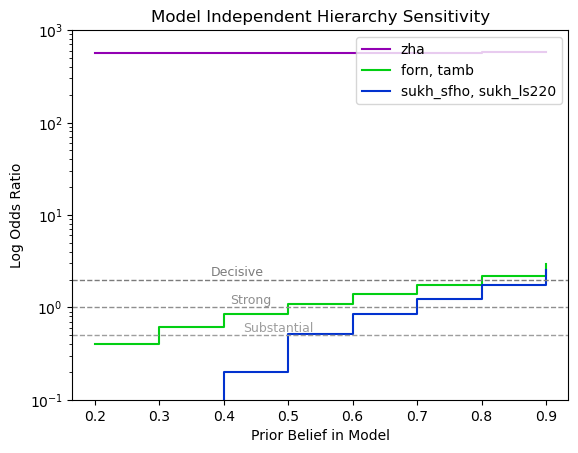

In [27]:
prior_list=np.linspace(.2,.9,8)
colors=['#9200b3','#02cf13','#0232cf']
names=['zha','forn','sukh_sfho',]
labels=['zha', 'forn, tamb', 'sukh_sfho, sukh_ls220']
linestyles=['-','-','-','-','-']
for i,mod_name in enumerate(names):
    if(ratios_nh[mod_name][0][0][0]<ratios[mod_name][0][0][0]):
        plt.step(prior_list,ratios_nh[mod_name][0][0],color=colors[i],where='post',label=labels[i],linestyle=linestyles[i])
    else:
        plt.step(prior_list,ratios[mod_name][0][0],color=colors[i],where='post',label=labels[i],linestyle=linestyles[i])
plt.legend(loc='upper right')
#plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.title('Model Independent Hierarchy Sensitivity')
plt.xlabel('Prior Belief in Model')
plt.ylabel('Log Odds Ratio')
plt.ylim(.1,10**3)
plt.axhline(y=2, color='#7B7B7B', linestyle='--', linewidth=1)
plt.axhline(y=1, color='#8F8F8F', linestyle='--', linewidth=1)
plt.axhline(y=.5, color='#9E9E9E', linestyle='--', linewidth=1)
plt.text(.38,2.2,'Decisive',fontsize=9,color='#7B7B7B')
plt.text(.41,1.1,'Strong',fontsize=9,color='#8F8F8F')
plt.text(.43,.55,'Substantial',fontsize=9,color='#9E9E9E')
plt.yscale('log')

In [14]:
def logs_to_ratios(log_prob_nh, log_prob_ih, priors, hierarchy):
    #log_prob_nh: length 5 array of log_p_d_nh for each model for a given dataset
    log_ratio=[]
    for i,prior in enumerate(priors):   
        p_nh=[]
        p_ih=[]
        for k,pro in enumerate(log_prob_nh):
            log_p_d_nh=log_prob_nh[k]
            log_p_d_ih=log_prob_ih[k]
                
            p_nh.append(log_p_d_nh-logsumexp([log_p_d_nh,log_p_d_ih])+np.log(prior[k]))
            p_ih.append(log_p_d_ih-logsumexp([log_p_d_nh,log_p_d_ih])+np.log(prior[k]))

        prob_nh=logsumexp(p_nh)
        prob_ih=logsumexp(p_ih)
            
        if(hierarchy==MassHierarchy.NORMAL):
            log_ratio.append(prob_nh-prob_ih)
        else:
            log_ratio.append(prob_ih-prob_nh)
            
    return log_ratio

In [53]:
prior_list=np.linspace(.2,.9,8)
sigma=5

models_nh=np.load('all_log_p_d_nh_sig={}.npz'.format(sigma),allow_pickle=True)['arr_0'].item()
models_ih=np.load('all_log_p_d_ih_sig={}.npz'.format(sigma),allow_pickle=True)['arr_0'].item()

forn_for_sfho_log_pd_nh=np.load('forn_for_sfho_log_pd_nh_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']
forn_for_sfho_log_pd_ih=np.load('forn_for_sfho_log_pd_ih_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']

tamb_for_sfho_log_pd_nh=np.load('tamb_for_sfho_log_pd_nh_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']
tamb_for_sfho_log_pd_ih=np.load('tamb_for_sfho_log_pd_ih_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']

forn_for_ls220_log_pd_nh=np.load('forn_for_ls220_log_pd_nh_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']
forn_for_ls220_log_pd_ih=np.load('forn_for_ls220_log_pd_ih_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']

tamb_for_ls220_log_pd_nh=np.load('tamb_for_ls220_log_pd_nh_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']
tamb_for_ls220_log_pd_ih=np.load('tamb_for_ls220_log_pd_ih_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']

zha_for_ls220_log_pd_nh=np.load('zha_for_ls220_log_pd_nh_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']
zha_for_ls220_log_pd_ih=np.load('zha_for_ls220_log_pd_ih_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']

#normal hierarchy
all_ratios_nh={
            'sukh_sfho': [],
            'sukh_ls220': [],
            'forn': [],
            'zha': [],
            'tamb': []
    }
for k in range(25):
    for i,mod_name in enumerate(ratios.keys()):
        all_priors=[]
        for j,prior in enumerate(prior_list):
            priors=[(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4]
            priors[i]=prior
            all_priors.append(priors)
            log_prob_nh=[]
            log_prob_ih=[]
        for l,name in enumerate(models_nh[mod_name].keys()):
            log_p_d_nh=models_nh[mod_name][name][0]
            log_p_d_ih=models_nh[mod_name][name][1]
            if(mod_name=='sukh_sfho' and name=='forn'):
                log_p_d_nh=forn_for_sfho_log_pd_nh[k]
                log_p_d_ih=forn_for_sfho_log_pd_ih[k]
            if(mod_name=='sukh_sfho' and name=='tamb'):
                log_p_d_nh=tamb_for_sfho_log_pd_nh[k]
                log_p_d_ih=tamb_for_sfho_log_pd_ih[k]
                    
            if(mod_name=='sukh_ls220' and name=='forn'):
                log_p_d_nh=forn_for_ls220_log_pd_nh[k]
                log_p_d_ih=forn_for_ls220_log_pd_ih[k]
                    
            if(mod_name=='sukh_ls220' and name=='tamb'):
                log_p_d_nh=tamb_for_ls220_log_pd_nh[k]
                log_p_d_ih=tamb_for_ls220_log_pd_ih[k]
                    
            if(mod_name=='sukh_ls220' and name=='zha'):
                log_p_d_nh=zha_for_ls220_log_pd_nh[k]
                log_p_d_ih=zha_for_ls220_log_pd_ih[k]
                    
            log_prob_nh.append(log_p_d_nh)
            log_prob_ih.append(log_p_d_ih)    
        ratios_nh=logs_to_ratios(log_prob_nh,log_prob_ih,all_priors,hierarchy=MassHierarchy.NORMAL)
        all_ratios_nh[mod_name].append(ratios_nh)
        
#inverted hierarchy
sfho_for_forn_log_pd_nh=np.load('sfho_for_forn_log_pd_nh_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']
sfho_for_forn_log_pd_ih=np.load('sfho_for_forn_log_pd_ih_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']

ls220_for_tamb_log_pd_nh=np.load('ls220_for_tamb_log_pd_nh_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']
ls220_for_tamb_log_pd_ih=np.load('ls220_for_tamb_log_pd_ih_sig_{}.npz'.format(sigma),allow_pickle=True)['arr_0']

all_ratios_ih={
            'sukh_sfho': [],
            'sukh_ls220': [],
            'forn': [],
            'zha': [],
            'tamb': []
}

for k in range(25):
    for i,mod_name in enumerate(ratios.keys()):
        all_priors=[]
        for j,prior in enumerate(prior_list):
            priors=[(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4]
            priors[i]=prior
            all_priors.append(priors)
            log_prob_nh=[]
            log_prob_ih=[]
        for l,name in enumerate(models_ih[mod_name].keys()):
            log_p_d_nh=models_ih[mod_name][name][0]
            log_p_d_ih=models_ih[mod_name][name][1]
            if(mod_name=='forn' and name=='sukh_sfho'):
                log_p_d_nh=sfho_for_forn_log_pd_nh[k]
                log_p_d_ih=sfho_for_forn_log_pd_ih[k]
                
            if(mod_name=='tamb' and name=='sukh_ls220'):
                log_p_d_nh=ls220_for_tamb_log_pd_nh[k]
                log_p_d_ih=ls220_for_tamb_log_pd_ih[k]

                    
            log_prob_nh.append(log_p_d_nh)
            log_prob_ih.append(log_p_d_ih)
                    
        ratios_ih=logs_to_ratios(log_prob_nh,log_prob_ih,all_priors,hierarchy=MassHierarchy.INVERTED)
        all_ratios_ih[mod_name].append(ratios_ih)

FileNotFoundError: [Errno 2] No such file or directory: 'all_log_p_d_nh_sig=5.npz'

In [34]:
tamb_for_sfho_log_pd_nh

array([-1208.25500101, -1174.08834873, -1229.38821505, -1202.89835498,
       -1245.16273582, -1272.93468749, -1327.47064175, -1238.50978286,
       -1258.30357506, -1211.54188571, -1301.40353307, -1291.10080441,
       -1366.99469197, -1212.42182007, -1213.57074831, -1275.66947465,
       -1135.2932137 , -1219.92836007, -1221.06035027, -1288.12651891,
       -1270.82842209, -1279.53604624, -1285.17489972, -1387.7150005 ,
       -1265.1820719 ])

In [33]:
tamb_for_sfho_log_pd_ih

array([-1144.87206841, -1207.68986142, -1160.1308267 , -1160.90230144,
       -1142.64335098, -1213.52481586, -1235.91897604, -1197.59163273,
       -1193.6321228 , -1171.29119716, -1228.77247676, -1226.08200806,
       -1272.98341752, -1159.06242762, -1169.64756266, -1185.62438358,
       -1079.3394586 , -1157.31600862, -1174.55307001, -1235.7165938 ,
       -1164.90164976, -1178.83291069, -1193.10428427, -1288.00892136,
       -1188.20586194])

In [35]:
all_ratios_nh

{'sukh_sfho': [[-0.40546510810759784,
   -0.10008345855650536,
   0.20067069546256355,
   0.5108256237663535,
   0.8472978603875276,
   1.2367626271492194,
   1.734601055388374,
   2.5123056239763604],
  [1.3862943611198881,
   1.5505974124111646,
   1.734601055388104,
   1.9459101490553108,
   2.197224577336217,
   2.512305623976112,
   2.9444389791664385,
   3.6635616461296445],
  [-0.4054651081081645,
   -0.10008345855698264,
   0.2006706954621511,
   0.5108256237659905,
   0.8472978603872033,
   1.2367626271489263,
   1.7346010553881066,
   2.512305623976115],
  [-0.4054651081081645,
   -0.10008345855698264,
   0.2006706954621511,
   0.5108256237659905,
   0.8472978603872033,
   1.2367626271489263,
   1.7346010553881066,
   2.512305623976115],
  [-0.4054651081081645,
   -0.10008345855698264,
   0.2006706954621511,
   0.5108256237659905,
   0.8472978603872033,
   1.2367626271489263,
   1.7346010553881066,
   2.512305623976115],
  [-0.4054651081081645,
   -0.10008345855698264,
   0.2

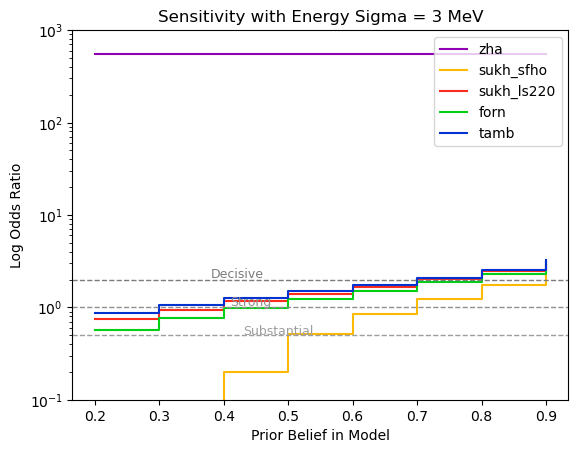

In [52]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

colors=['#9200b3','#fcba03','#fc2b1c','#02cf13','#0232cf']
names=['zha','sukh_sfho','sukh_ls220','forn','tamb']
linestyles=['-','-','-','-','-']
ratio_mins={
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

for i,mod_name in enumerate(names):
    means_nh=np.mean(all_ratios_nh[mod_name], axis=0)
    means_ih=np.mean(all_ratios_ih[mod_name], axis=0)
    if(means_nh[0]<means_ih[0]):
        plt.step(prior_list,means_nh,color=colors[i],where='post',label=mod_name,linestyle=linestyles[i])
        ratio_mins[mod_name]=means_nh
    else:
        plt.step(prior_list,means_ih,color=colors[i],where='post',label=mod_name,linestyle=linestyles[i])
        ratio_mins[mod_name]=means_ih
plt.legend(loc='upper right')


plt.title('Sensitivity with Energy Sigma = 3 MeV')
plt.xlabel('Prior Belief in Model')
plt.ylabel('Log Odds Ratio')
plt.ylim(.1,10**3)
plt.axhline(y=2, color='#7B7B7B', linestyle='--', linewidth=1)
plt.axhline(y=1, color='#8F8F8F', linestyle='--', linewidth=1)
plt.axhline(y=.5, color='#9E9E9E', linestyle='--', linewidth=1)
plt.text(.38,2.1,'Decisive',fontsize=9,color='#7B7B7B')
plt.text(.41,1.05,'Strong',fontsize=9,color='#8F8F8F')
plt.text(.43,.51,'Substantial',fontsize=9,color='#9E9E9E')
plt.yscale('log')